<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-records" data-toc-modified-id="Load-records-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load records</a></span></li><li><span><a href="#Transforms-and-dataloaders" data-toc-modified-id="Transforms-and-dataloaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transforms and dataloaders</a></span></li><li><span><a href="#Model-and-training" data-toc-modified-id="Model-and-training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model and training</a></span></li><li><span><a href="#Show-results" data-toc-modified-id="Show-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Show results</a></span></li></ul></div>

In [1]:
from mantisshrimp.all import *

## Load records

In [2]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [3]:
class PersonImageParser(ImageParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        # Get size
        sz = self.lines.filter(lambda o: o.startswith('Image size (X x Y x C)'))[0]
        sz = re.search(r'\d{3,4}\sx\s\d{3,4}\sx\s3', sz).group()
        self.sz = lmap(int, sz.split('x'))
        
    def iid(self, o): return self.i
    def file_path(self, o):
        fp = self.lines.filter(lambda o: o.startswith('Image filename'))[0]
        fp = re.findall(r'"(.*)"', fp)[0]
        return self.source.parent/fp
    
    def width(self, o):  return self.sz[0]
    def height(self, o): return self.sz[1]

In [4]:
class PersonAnnotationParser(AnnotationParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        ln = self.lines.filter(lambda o: o.startswith('Objects with ground truth'))[0]
        self.n = int(re.findall('\d+', ln)[0])
        
    def iid(self, o): return self.i
    def oid(self, o): return [0]*self.n
    def iscrowd(self, o): return [0]*self.n
        
    def bbox(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Bounding box'))
        bboxes = []
        for bbox in lines:
            bbox = re.findall(r'(\d+,\s\d+)', bbox)
            bbox = lmap(lambda o: lmap(int, o.split(',')), bbox)
            bbox = np.array(bbox).flat
            bboxes.append(BBox.from_xyxy(*bbox))
        return bboxes
    
    def seg(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Pixel mask for object'))
        line = lines[0] # All lines contain the same mask
        fp = self.source.parent/re.findall(r'"(.+)"', line.split(':')[-1])[0]
        return MaskFile(fp)

In [5]:
fns = get_files(source/'Annotation', extensions='.txt')

In [6]:
catmap = CategoryMap([Category(0, 'person')])

In [7]:
parser = DataParser(fns, source, catmap, img_parser=PersonImageParser, annot_parser=PersonAnnotationParser)
train_rs,valid_rs = parser.parse()


Removed 0 images that don't have annotations


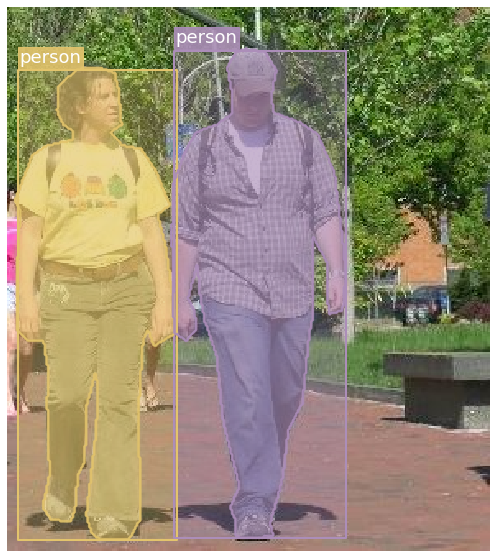

In [8]:
show_record(r=random.choice(train_rs), catmap=catmap)

## Transforms and dataloaders

In [9]:
# tfm = AlbuTfm([A.HorizontalFlip(), A.Rotate(10, border_mode=cv2.BORDER_CONSTANT)])
tfm = AlbuTfm([A.HorizontalFlip(),
#                A.Rotate(p=.7, limit=10, border_mode=cv2.BORDER_CONSTANT),
#                A.RGBShift(), A.RandomBrightness(), A.RandomContrast(),
#                A.RandomFog(.1,.5),
              ])

In [10]:
train_ds = Dataset(train_rs, tfm)
valid_ds = Dataset(valid_rs)

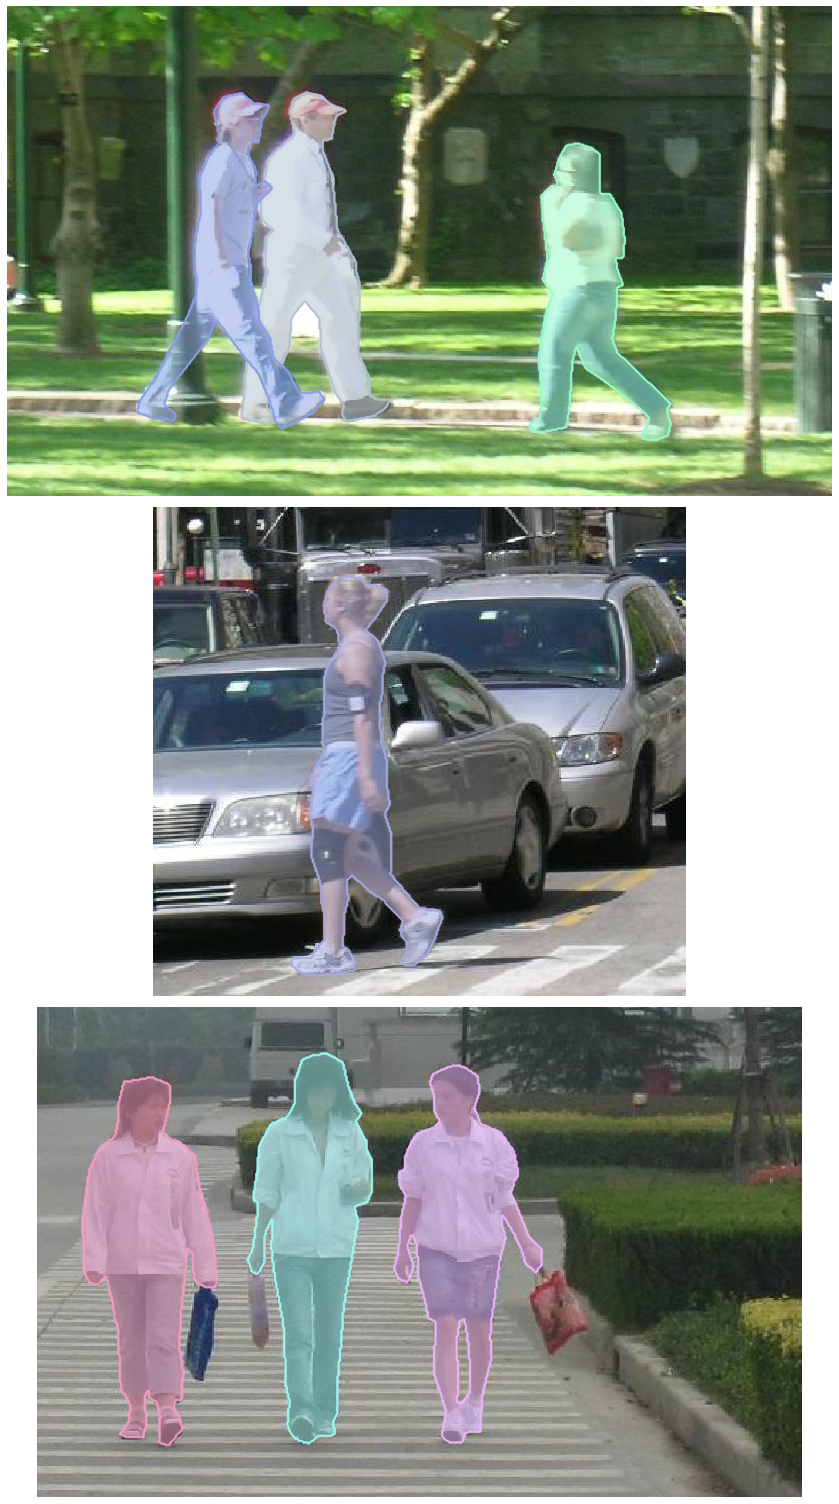

In [11]:
items = random.choices(train_ds, k=3) # Different items
# items = [train_ds[3] for _ in range(3)] # Same item
grid2([partial(show_item, item, bbox=False, label=False, catmap=catmap) for item in items])

## Model and training

In [12]:
# TODO: Import only necesary names
from torch.optim.lr_scheduler import *
from pytorch_lightning.callbacks import LearningRateLogger
from pytorch_lightning import loggers
tb_logger = loggers.TensorBoardLogger('lightning_logs', 'person')

In [13]:
metrics = [COCOMetric(valid_rs, catmap)]


creating index...
index created!


In [14]:
def warmup_scheduler(steps, factor):
    def _inner(step):
        if step > steps: return 1.
        alpha = float(step) / steps
        return factor * (1-alpha) + alpha
    return _inner

In [15]:
class MyLearner(Learner):
    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        opt = torch.optim.SGD(params, 5e-3, momentum=0.9, weight_decay=5e-4)
#         step_lr = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
#         warmup = {
#             'scheduler': LambdaLR(opt, warmup_scheduler(1e3, 1e-3)),
#             'interval': 'step',
#         }
        onecycle = {
            'scheduler': OneCycleLR(opt, 5e-3, total_steps=68*10),
            'interval': 'step',
        }
        return [opt], [onecycle]

In [16]:
model = maskrcnn(len(catmap))
learn = MyLearner(model, metrics=metrics)

In [17]:
dl_train = RCNNDataLoader(train_ds, batch_size=2, num_workers=8)
dl_valid = RCNNDataLoader(valid_ds, batch_size=4, shuffle=False, num_workers=8)

In [18]:
trainer = Trainer(max_epochs=10, gpus=1, loggers=tb_logger, callbacks=[LearningRateLogger()])

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [19]:
trainer.fit(learn, dl_train, dl_valid)


    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 43 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   | Bottleneck   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.086
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.969
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: The metric you returned None must be a Torch.Tensor instance, checkpoint not saved HINT: what is the value of val_loss in validation_end()?
  warnings.warn(*args, **kwargs)
/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)


Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.744

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.788
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.959
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.828
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.828
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.756

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778

Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.970
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.836
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.836
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.756

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.969
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.826
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722

Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.837
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.837
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.733

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.830
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.830
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767

Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.822
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.848
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.848
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.778

Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.943
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.824
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.849
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.849
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.756

1

## Show results

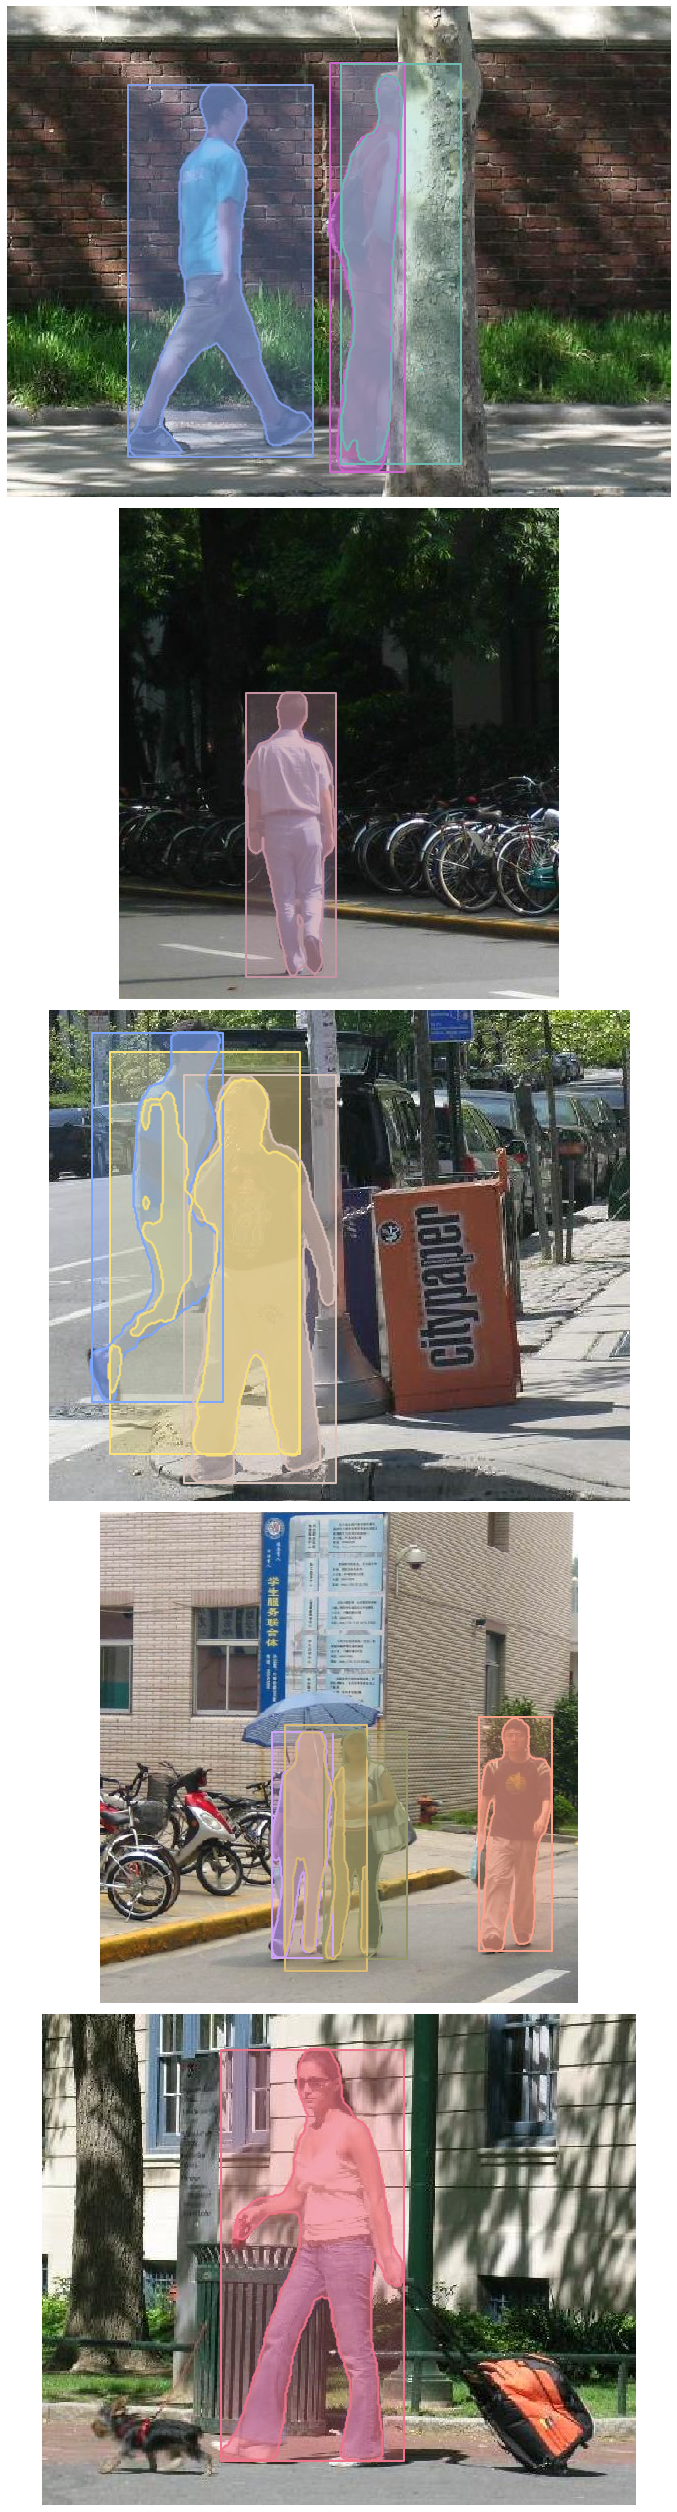

In [21]:
rs = random.choices(valid_rs, k=5)
ims,preds = learn.predict(rs=rs)
show_preds(ims, preds)